<a href="https://colab.research.google.com/gist/morganmcg1/37b8cf35bcdfef8864003c017344ef6a/basic_transformer_w_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# credits to @lucidrains https://github.com/lucidrains

In [2]:
# import sys
# if 'google.colab' in sys.modules:
#     !pip install -qq einops

In [3]:
!pip install einops

Download and unzip enwik8 dataset

In [4]:
#!wget -P data/ http://mattmahoney.net/dc/enwik8.zip

#!unzip data/enwik8.zip -d data/

#!ls data

#!head -n 132 data/enwik8

In [5]:
import math
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from inspect import isfunction

from einops import rearrange, reduce #

In [6]:
import six

In [7]:
# helpers

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

## Helpers and FeedForward

In [8]:
# helper classes 
# form https://github.com/lucidrains/all-normalization-transformer/blob/master/all_normalization_transformer/all_normalization_transformer.py

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
# Added *args, **kwargs here to pass context and masks
class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.fn(x)
        return self.norm(x, *args, **kwargs)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)
#TODO add inner dropout to ff
class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [9]:
bs = 8
sl = 512
d = 1024
x = torch.randn(bs, sl, d)
ff  = Residual(PreNorm(d, FeedForward(d)))
out = ff(x)
out.shape

torch.Size([8, 512, 1024])

In [10]:
ff

Residual(
  (fn): PreNorm(
    (fn): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=4096, out_features=1024, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

## Attention

In [11]:
MASK_VAL = -1e4 # float('-inf')

In [12]:
class Attention(nn.Module):
    def __init__(self, 
                 dim, 
                 heads = 8, 
                 causal = False,
                 mask = None,
                 dropout=0.1):
        super().__init__()
        self.causal = causal
        self.mask = mask #??
        self.heads = heads
        self.scale = dim ** -0.5
        
        self.to_q = nn.Linear(dim, dim, bias = False)
        self.to_kv = nn.Linear(dim, dim * 2, bias = False)
        self.dropout = nn.Dropout(dropout)

        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, context = None, mask = None, context_mask = None):
        b, n, _, h, device = *x.shape, self.heads, x.device
        kv_input = default(context, x)

        q_ = self.to_q(x)
        kv = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q_, *kv))
        # pdb.set_trace()
        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            input_mask = q_mask * k_mask

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        # might need to tune MASK_VAL for fp16 to work
        if exists(input_mask):
            dots.masked_fill_(~input_mask, MASK_VAL)
            del input_mask

        if self.causal:
            i, j = dots.shape[-2:]
            mask = torch.ones((i, j), device = device).triu_(j - i + 1).bool()
            dots.masked_fill_(mask, MASK_VAL)
            del mask

        attn = F.softmax(dots, -1)
        attn = self.dropout(attn)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [13]:
x = torch.randn(bs, sl, d)
attn  = Residual(PreNorm(d, Attention(d)))
out = attn(x)
out.shape

torch.Size([8, 512, 1024])

In [14]:
# TODO test with context, masks
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-20, d)
attn  = Residual(PreNorm(d, Attention(d)))

out = attn(x, context)
out.shape

torch.Size([8, 512, 1024])

## Transformer blocks

### Encoder

In [15]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, heads = 8, causal = False, mask = None, 
                 attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.attn = Residual(PreNorm(dim, Attention(dim, causal=causal, dropout=attn_dropout)))
        self.ff = Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout)))
    def forward(self, x, mask=None): #? more args
        out = self.attn(x, mask=mask)
        out = self.ff(out)
        return out

In [16]:
x = torch.randn(bs, sl, d)
m = TransformerEncoderBlock(d)
out = m(x)
out.shape

torch.Size([8, 512, 1024])

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, causal=False, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoderBlock(dim, heads, causal=causal, attn_dropout=attn_dropout, ff_dropout=ff_dropout))
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

In [18]:
x = torch.randn(bs, sl, d)
m = TransformerEncoder(d)
out = m(x)
out.shape

torch.Size([8, 512, 1024])

Decoder block has attention and cross attention

### Decoder

In [19]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, heads = 8, mask = None, 
                 attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.attn = Residual(PreNorm(dim, Attention(dim, causal=True, dropout=attn_dropout)))
        self.cross = Residual(PreNorm(dim, Attention(dim, causal=False, dropout=attn_dropout)))
        self.ff = Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout)))

    def forward(self, x, context, mask=None, context_mask=None):
        out = self.attn(x, mask=mask)
        out = self.cross(out, context, mask=mask, context_mask=context_mask)
        out = self.ff(out)
        return out

In [20]:
class TransformerDecoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerDecoderBlock(dim, heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout))
    def forward(self, x, context, mask=None, context_mask=None):
        for layer in self.layers:
            x = layer(x, context, mask, context_mask)
        return x

### Models

In [21]:
class TransformerEmbedding(nn.Module):

    def __init__(self, emb_sz, dim, max_seq_len=512, dropout=0.):
        super().__init__()
        self.emb = nn.Embedding(emb_sz, dim)
        self.pos_enc = nn.Embedding(max_seq_len, dim)
        self.dropout = nn.Dropout(dropout)
        self._init()
    def forward(self, x):
        _, n = x.shape
        x = self.emb(x)
        x += self.pos_enc(torch.arange(n, device=x.device))
        return self.dropout(x)
    def _init(self):
        nn.init.normal_(self.emb.weight, std = 0.02)
        nn.init.normal_(self.pos_enc.weight, std = 0.02)

In [22]:
#TODO add weight tying

In [23]:
import pdb

In [24]:
#TODO not tested
class TransformerEncDec(nn.Module):
    def __init__(self, enc_vocab_sz, dec_vocab_sz, dim, depth=6, heads=8, max_seq_len=512, pad_idx=None):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.pad_idx = pad_idx
        self.enc_emb = TransformerEmbedding(enc_vocab_sz, dim, max_seq_len)
        self.dec_emb = TransformerEmbedding(dec_vocab_sz, dim, max_seq_len)
        self.encoder = TransformerEncoder(dim, depth, heads)
        self.decoder = TransformerDecoder(dim, depth, heads)
        self.proj = nn.Linear(dim, dec_vocab_sz)

    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_mask = default(src_mask, self.get_padding_mask(src))
        #pdb.set_trace()
        tgt_mask = default(tgt_mask, self.get_padding_mask(tgt))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = self.decoder(self.dec_emb(tgt), context=enc, mask=tgt_mask, context_mask=src_mask)
        
        #debug return 
        # return self.proj(out), enc, out
        return self.proj(out)
    def get_padding_mask(self, x):
        assert self.pad_idx is not None
        return (x != self.pad_idx)

In [25]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
                 max_seq_len=512, tie_weights=False,
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        self.tfmr = TransformerEncoder(dim, depth, heads, causal=causal,
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout)
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
        
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.tfmr(x, mask=mask)
        return self.proj(x)

### Test LM

In [26]:
#!pip install -Uqq fastai

In [27]:
from fastai.text.all import *

In [28]:
# path = untar_data(URLs.IMDB_SAMPLE)
# path.ls()

In [29]:
# df = pd.read_csv(path/'texts.csv')
# df.head(2)

In [30]:
def read_lines(path):
    """Tokenizes a text file."""
    assert os.path.exists(path)
    lines=[]
    with open(path, 'r') as f:
        tokens = 0
        for line in f:
            lines.append(line)  # + ['<eos>'])            
    return lines

enwik8 = read_lines('data/enwik8')
len(enwik8),enwik8[0]

df = pd.DataFrame({'text':enwik8})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


### Create ByteTextEncoder

In [31]:
class ByteTextTokenizer(Transform):
    """
        Encodes each byte to an id. For 8-bit strings only.
        Credit: https://github.com/tensorflow/tensor2tensor/blob/5f9dd2db6d7797162e53adf152310ed13e9fc711/tensor2tensor/data_generators/text_encoder.py#L176
    """
    def __init__(self, is_lm=True):
        self.ls_lm = is_lm
        self.pad_token, self.eos_token, self.bos_token = '<pad>', '<eos>', '<bos>',
        self.pad_token_id, self.eos_token_id, self.bos_token_id = 0,1,2
        self.reserved_toks = [self.pad_token, self.eos_token, self.bos_token]  ## self.bos_token_id 
        self.reserved_tokens_bytes = [bytes(rtok, 'ascii') for rtok in self.reserved_toks]
        self.numres = len(self.reserved_toks)
        self.int2byte = six.int2byte

    @typedispatch
    def __call__(self, o:list, **kwargs):
        if self.ls_lm: return LMTensorText([c + self.numres for s in o for c in s.encode("utf-8")])
        else: return TensorText([c + self.numres for s in o for c in s.encode("utf-8")])
    
    @typedispatch
    def __call__(self, o:str, **kwargs):
        if self.ls_lm: return LMTensorText([c + self.numres for c in o.encode("utf-8")])
        else: return TensorText([c + self.numres for c in o.encode("utf-8")]) 
    
    def encodes(self,o):
        return self.__call__(o)
    
    def decodes(self, o:tuple):
        decoded_ids = ()
        for i in o:
            tmp_ls=[]
            for id_ in i:
                if 0 <= id_ < self.numres: tmp_ls.append(self.reserved_tokens_bytes[int(id_)])
                else: tmp_ls.append(self.int2byte(id_ - self.numres))
            decoded_ids = decoded_ids + (b"".join(tmp_ls).decode("utf-8", "replace"),)
        return TitledStr(decoded_ids)
    
    def decodes(self, o:list):
        decoded_ids = []
        for id_ in o:
            if 0 <= id_ < self.numres: decoded_ids.append(self.reserved_tokens_bytes[int(id_)])
            else: decoded_ids.append(self.int2byte(id_ - self.numres))
        return TitledStr(b"".join(decoded_ids).decode("utf-8", "replace"))
    
    def decodes(self, o:TensorText):
        return self.decodes(o.tolist())
    
    def decodes(self, o:LMTensorText):
        return self.decodes(o.tolist())
    
    @property
    def vocab_size(self): return 2**8 + self.numres

In [32]:
bte = ByteTextTokenizer(is_lm=True)
bte.vocab_size

259

In [33]:
enc_t = bte('Am I working?'); enc_t

LMTensorText([ 68, 112,  35,  76,  35, 122, 114, 117, 110, 108, 113, 106,  66])

In [34]:
# Test tokenization
enc_t = bte(['Am I working?']); enc_t

LMTensorText([ 68, 112,  35,  76,  35, 122, 114, 117, 110, 108, 113, 106,  66])

In [35]:
# Test decodes with list of ids
bte.decodes(enc_t.tolist() + [0])

'Am I working?<pad>'

In [36]:
# Test decodes with tuples 
tt = TensorText(tensor(L(1,2,3,5)))
ee = TensorText(tensor(enc_t))

bte.decodes((tt,)), bte.decodes((ee,)), bte.decodes((ee,ee))

("('<eos><bos>\\x00\\x02',)",
 "('Am I working?',)",
 "('Am I working?', 'Am I working?')")

Add EOS at the Dataloder stage

In [58]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
#     return LMTensorText(txt[:-1]),txt[1:]
    return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

Prep data

In [80]:
df = df.iloc[:196].copy()

In [81]:
df['lens'] = df['text'].str.len()

### Train/Test Splits

The Tensor2Tensor library divides the library into train/eval/test set of 89M / 5M / 5M respectively

In [82]:
df['lens_cum_sum'] = df.lens.cumsum()
if len(df) < 100000:  train_cutoff = 5000  # for testing
else:  train_cutoff = df.lens.sum() - 10000000; train_cutoff  # for production

In [83]:
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

train_idxs[-1], validation_idxs[-1], test_idxs[-1]

(129, 161, 195)

### Dataset

In [84]:
splits = [train_idxs, validation_idxs]
lens = [df.iloc[:max(train_idxs)].lens.values, df.iloc[max(train_idxs):max(validation_idxs)].lens.values]

tfms = [attrgetter("text"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader) #dl_type=partial(LMDataLoader, lens=lens))

### Dataloader

In [85]:
bs,sl = 64,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [86]:
dls.show_batch()

,text,text_
0,"<namespace key=""9"">MediaWiki talk</namespace>\n <namespace key=""13<eos>","<namespace key=""9"">MediaWiki talk</namespace>\n <namespace key=""13""<eos>"
1,""">Help talk</namespace>\n <username>CJames745</username>\n <text x<eos>",>Help talk</namespace>\n <username>CJames745</username>\n <text xm<eos>
2,"ml:space=""preserve"">#REDIRECT [[AAA]]</text>\n <text xml:space=""preserve<eos>","l:space=""preserve"">#REDIRECT [[AAA]]</text>\n <text xml:space=""preserve""<eos>"
3,""">#REDIRECT [[Applied ethics]]\n <text xml:space=""preserve"">{{Anarchism}<eos>",">#REDIRECT [[Applied ethics]]\n <text xml:space=""preserve"">{{Anarchism}}<eos>"
4,"}\n <namespace key=""11"">Template talk</namespace>\n <siteinfo>\n </page><eos>","\n <namespace key=""11"">Template talk</namespace>\n <siteinfo>\n </page>\n<eos>"
5,"\n <revision>\n <title>AdA</title>\n <namespace key=""-1"">Special</na<eos>","<revision>\n <title>AdA</title>\n <namespace key=""-1"">Special</nam<eos>"
6,"mespace>\n </page>\n <namespace key=""12"">Help</namespace>\n <revision><eos>","espace>\n </page>\n <namespace key=""12"">Help</namespace>\n <revision>\n<eos>"
7,\n <id>5</id>\n <title>AmericanSamoa</title>\n <revision>\n <id>11</<eos>,<id>5</id>\n <title>AmericanSamoa</title>\n <revision>\n <id>11</i<eos>
8,id>\n <contributor>\n <id>8029</id>\n </revision>\n <usern<eos>,d>\n <contributor>\n <id>8029</id>\n </revision>\n <userna<eos>


In [87]:
u = dls.one_batch()
u[0][0], u[1][0]

(LMTensorText([ 35,  35,  63,  50, 115, 100, 106, 104,  65,  13,  35,  35,  35,  35,
          35,  35,  63, 112, 108, 113, 114, 117,  35,  50,  65,  13,  35,  35,
          35,  35,  63,  50, 117, 104, 121, 108, 118, 108, 114, 113,  65,  13,
          35,  35,  35,  35,  35,  35,  63, 119, 108, 112, 104, 118, 119, 100,
         112, 115,  65,  53,  51,  51,  56,  48,  51,  58,  48,  51,  54,  87,
          52,  52,  61,  52,  55,  61,   1], device='cuda:0'),
 LMTensorText([ 35,  63,  50, 115, 100, 106, 104,  65,  13,  35,  35,  35,  35,  35,
          35,  63, 112, 108, 113, 114, 117,  35,  50,  65,  13,  35,  35,  35,
          35,  63,  50, 117, 104, 121, 108, 118, 108, 114, 113,  65,  13,  35,
          35,  35,  35,  35,  35,  63, 119, 108, 112, 104, 118, 119, 100, 112,
         115,  65,  53,  51,  51,  56,  48,  51,  58,  48,  51,  54,  87,  52,
          52,  61,  52,  55,  61,  52,   1], device='cuda:0'))

In [88]:
# def add_eos(text):
#     return text + f' {EOS}'

In [89]:
# dls = DataBlock(blocks=TextBlock.from_df('text', is_lm=True, rules=[add_eos], seq_len=128),
#                 get_x=ColReader('text'), splitter=RandomSplitter(0.1)).dataloaders(df, bs=16)

# dls.show_batch(max_n=2)

In [90]:
# vocab_sz = len(dls.vocab)
vocab_sz = bte.vocab_size

In [91]:
xb, yb = dls.one_batch()
model = TransformerLM(vocab_sz, 256, depth=2)

In [92]:
model

TransformerLM(
  (emb): TransformerEmbedding(
    (emb): Embedding(259, 256)
    (pos_enc): Embedding(512, 256)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (tfmr): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderBlock(
        (attn): Residual(
          (fn): PreNorm(
            (fn): Attention(
              (to_q): Linear(in_features=256, out_features=256, bias=False)
              (to_kv): Linear(in_features=256, out_features=512, bias=False)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_out): Linear(in_features=256, out_features=256, bias=True)
            )
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
        )
        (ff): Residual(
          (fn): PreNorm(
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=256, out_features=1024, bias=True)
                (1): GELU()
                (2): Dropout(p=0.1, inplace=False)
     

In [93]:
with torch.no_grad():
    out = model(xb.cpu())
out.shape

torch.Size([64, 77, 259])

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=0.0005754399462603033)

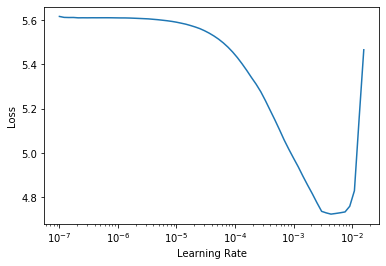

In [94]:
learn = Learner(dls, TransformerLM(vocab_sz, 256, depth=2), metrics=[accuracy, Perplexity()], 
                loss_func=CrossEntropyLossFlat(), wd=0.1).to_fp16()
learn.lr_find()

In [76]:
# learn = Learner(dls, TransformerLM(vocab_sz, 256, depth=2), metrics=[accuracy, Perplexity()], 
#                 loss_func=CrossEntropyLossFlat(), path=path, wd=0.1).to_fp16()
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(200, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.617491,5.499463,0.001843,244.560593,00:00
1,5.578623,5.441739,0.006451,230.843292,00:00
2,5.536295,5.389686,0.036572,219.134491,00:00
3,5.498603,5.329277,0.091185,206.288788,00:00
4,5.456856,5.270901,0.111895,194.591156,00:00
5,5.415128,5.205172,0.114017,182.212128,00:00
6,5.371389,5.133224,0.116479,169.562988,00:00
7,5.323670,5.061411,0.117898,157.813019,00:00
8,5.274966,4.986437,0.119039,146.413803,00:00
9,5.223014,4.915466,0.119099,136.382889,00:00


In [ ]:
learn.recorder.plot_loss()

In [36]:
#TODO initialization

In [37]:
# learn = language_model_learner(dls, AWD_LSTM, pretrained=False, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()
# learn.fit_one_cycle(5, 1e-2)

# (END enwik8 test)

### Test EncoderDecoder

In [39]:
path = Path()
df = pd.read_csv(path/'en_ga_prep.csv', index_col=0)
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [58]:
df = df[:48]

In [59]:
def add_eos(text):
    return text + f' {EOS}'

In [60]:
dblock = DataBlock(blocks=(TextBlock.from_df('en', tok_text_col='en', rules=[add_eos]),
                           TextBlock.from_df('ga', tok_text_col='ga', rules=[add_eos])),
                   get_x=ColReader('en'),
                   get_y=ColReader('ga'), 
                   splitter=RandomSplitter())

In [61]:
dsets = dblock.datasets(df)

In [62]:
pad_seq2seq = partial(pad_input, pad_fields=[0,1])

In [63]:
dls = dsets.dataloaders(bs=16, dl_type=SortedDL, before_batch=pad_seq2seq)
dls.show_batch(max_n=4)

,text,text_
0,"Some species could be lost as the horseshoe bat Small ( contacted August 1955 Port - Cros and November 1956 Porquerolles ( Aellen , 1998 ) ) for which no recent data exists on a French PIM . xxeos","D'fhéadfaí roinnt speiceas a bheith caillte mar an chrú - ialtóg Beag ( i dteagmháil Lúnasa 1955 Port - Cros agus Samhain 1956 Porquerolles ( Aellen , 1998 ) ) nach bhfuil aon sonraí le déanaí ann ar PIM Fraince . xxeos xxpad xxpad xxpad xxpad xxpad"
1,"Some species could be lost as the horseshoe bat Small ( contacted August 1955 Port - Cros and November 1956 Porquerolles ( Aellen , 1998 ) ) for which no recent data exists on a French PIM . xxeos","D'fhéadfaí roinnt speiceas a bheith caillte mar an chrú - ialtóg Beag ( i dteagmháil Lúnasa 1955 Port - Cros agus Samhain 1956 Porquerolles ( Aellen , 1998 ) ) nach bhfuil aon sonraí le déanaí ann ar PIM Fraince . xxeos xxpad xxpad xxpad xxpad xxpad"
2,""" xxunk xxunk from the xxunk to xxunk the xxunk xxunk not , xxunk xxunk xxunk that xxunk , the xxunk to xxunk in the xxunk xxunk xxunk is xxunk xxunk for xxunk and xxunk xxunk "" xxeos xxpad",""" xxunk xxunk an xxunk a bheith ar an xxunk xxunk nach xxunk , xxunk xxunk xxunk a xxunk go xxunk xxunk xxunk ann , is é an xxunk go xxunk xxunk sa xxunk an xxunk xxunk xxunk - xxunk do xxunk agus xxunk xxunk "" xxeos"
3,""" xxunk xxunk xxunk are one xxunk xxunk , xxunk xxunk "" . xxunk this is xxunk xxunk xxunk xxunk , xxunk xxunk xxunk are not xxunk xxunk xxunk is xxunk it . xxeos xxpad xxpad xxpad xxpad xxpad",""" Tá xxunk xxunk xxunk xxunk mór xxunk , xxunk mór . "" xxunk go bhfuil an xxunk seo go xxunk xxunk ann xxunk xxunk , ach xxunk xxunk nach bhfuil ann a xxunk xxunk é xxunk leis . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad"


In [64]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

In [65]:
class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

In [66]:
class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

In [67]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768

In [68]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 39]), torch.Size([16, 47]))

In [81]:
model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, d_model, pad_idx=dls.o2i[0][PAD], max_seq_len=256, depth=2)

In [82]:
#%debug model(xb, yb[:,:-1])

In [83]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]
learn = Learner(dls, TransformerEncDec(en_vocab_sz, ga_vocab_sz, d_model, pad_idx=dls.o2i[0][PAD], max_seq_len=256, depth=6),
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_fp16()

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=1.9054607491852948e-06)

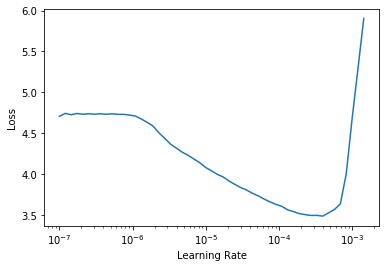

In [78]:
learn.lr_find()

In [84]:
learn.fit_one_cycle(180, 3e-5, div=5)

epoch,train_loss,valid_loss,accuracy,corpus_bleu,time
0,4.566063,4.604934,0.006838,0.004735,00:01
1,4.569985,4.604934,0.006838,0.004735,00:01
2,4.565427,4.604934,0.006838,0.004735,00:01
3,4.563926,4.604934,0.006838,0.004735,00:01
4,4.568338,3.899116,0.147009,0.050542,00:02
5,4.410837,3.606696,0.145299,0.050232,00:02
6,4.259591,3.132521,0.147009,0.050542,00:01
7,4.088620,3.074820,0.150427,0.051569,00:02
8,3.959558,3.056220,0.153846,0.052190,00:02
9,3.841872,2.852678,0.152137,0.051907,00:01


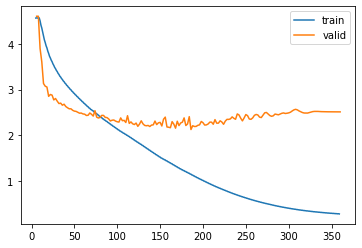

In [85]:
learn.recorder.plot_loss()